# Imports

In [16]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

import os

import utils

import pathlib

print(tf.__version__)

2.10.0


# Load training images (Ignore)
Load images from the [assets] folder and scan them into arrays.

In [2]:
# Path to traning data
path = "../assets/train/"
# First file to analyze '0' is the first file in each directory
file_start = 0

# Number of files in each directory to load
file_count = 1500 # 1500

# Last file to load in each directory
file_end = file_start + file_count

# Numer of permutations for generating additional training data
num_permutations = 24

dirs = ["","","","","","","","","","","","","","","","","","","","","","","","",]
for i in range(num_permutations):
  dirs[i] = f"{utils.perms[i][0]:d}{utils.perms[i][1]:d}{utils.perms[i][2]:d}{utils.perms[i][3]:d}"

image_width = 128
image_height = 128

# Pre-allocate a large numpy array to store training data
training_images = np.zeros((file_count * len(dirs), image_width, image_height), dtype=np.float32)

# Store labels for the training images
training_labels = np.zeros(file_count * len(dirs))

# Missing offset (If file fails to open, avoid including empty arrays in the testing set with this offset)
miss = 0

# Iterate through each directory, loading [file_count] images from each into the [training_images] array
for i in range(len(dirs)):
  for j in range(file_start, file_end):
    # Parse a path for the file to load
    in_path = path + dirs[i] + "/" + f'{j:05d}' + ".png"
    try:
      # Graryscale the image to reduce data size given to the machine
      im = ImageOps.grayscale(Image.open(in_path))
      # if j >= 100 and dirs[i] != "0123":
      #   # Increment miss counter to avoid zero arrays in the training data
      #   miss += 1
      #   continue
    except FileNotFoundError:
      # Increment miss counter to avoid zero arrays in the training data
      miss += 1
      continue
    # Calculate index
    idx = i*file_count + j - miss
    temp_arr =  np.asarray(im, dtype=np.uint8)/255 # Normalize
    # Add images to training data
    training_images[idx] = temp_arr
    # Add label
    if dirs[i] == "0123":
      # Assign '1' for correct-ordered image
      training_labels[idx] = 1
    else:
      # Assign '0' for incorrect-ordered image
      training_labels[idx] = 0 
# Trim missing data off of the training data
training_images.resize((file_count * len(dirs) - miss, image_width, image_height))
training_labels.resize((file_count * len(dirs) - miss))

# Convert to unsigned integer
training_labels = training_labels.astype(np.uint8)

print(training_images.shape)


(36000, 128, 128)


# Preprocessing (Ignore)

Correct


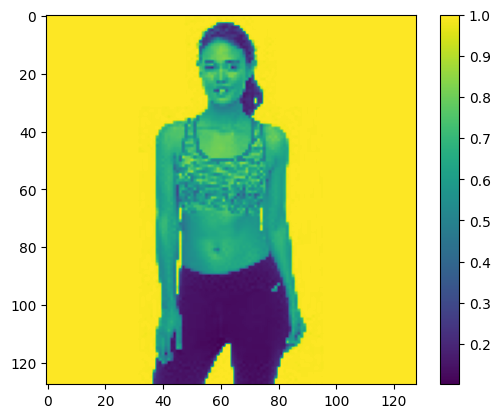

In [3]:
class_names = ['Incorrect', 'Correct']

idx = 10

res = training_images[idx]
print(class_names[training_labels[idx]])

plt.figure()
plt.imshow(res)
plt.colorbar()
plt.grid(False)
plt.show()


# Show additional images (Ignore)

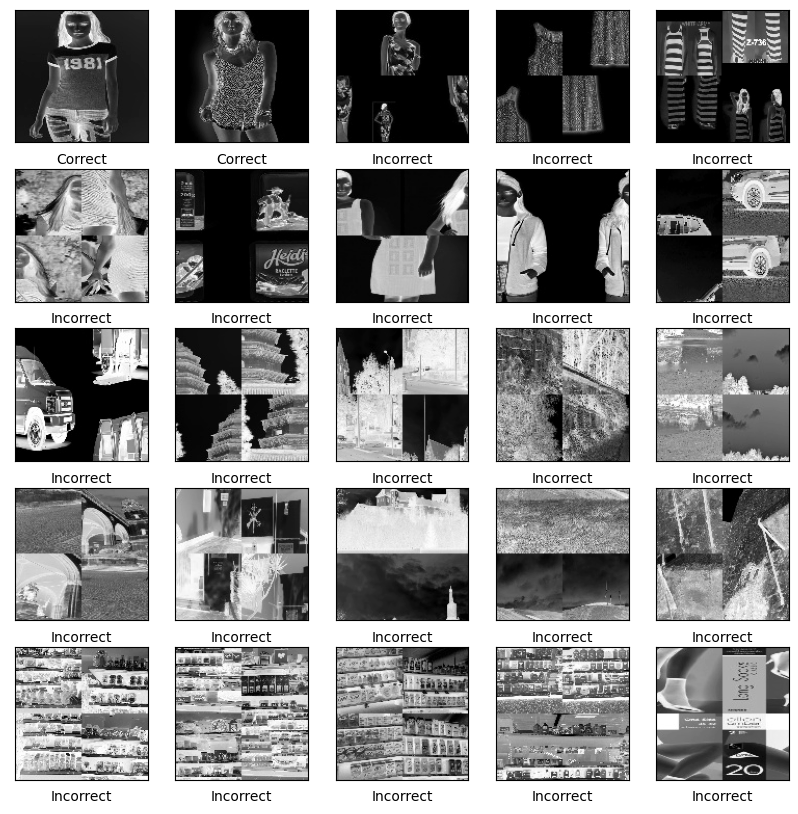

In [4]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i*(int(len(training_labels)/25))], cmap=plt.cm.binary)
    plt.xlabel(class_names[training_labels[i*(int(len(training_labels)/25))]])
plt.show()

# Generate testing data (Ignore)

In [5]:
file_start = 0
file_end = 500

# Pre-allocate a large numpy array to store testing data
testing_images = np.zeros((file_end * len(dirs), image_width, image_height), dtype=np.float32)

# Store labels for the testing images
testing_labels = np.zeros(file_end * len(dirs))

# Missing offset (If file fails to open, avoid including empty arrays in the testing set with this offset)
miss = 0



# Iterate through each directory, loading [file_count] images from each into the [training_images] array
for i in range(len(dirs)):
  for j in range(file_start, file_end):
    # Parse a path for the file to load
    in_path = path + dirs[i] + "/" + f'{j + file_count:05d}' + ".png"
    try:
      # Graryscale the image to reduce data size given to the machine
      im = ImageOps.grayscale(Image.open(in_path))
      # if j >= 1600 and dirs[i] != "0123":
      #   # Increment miss counter to avoid zero arrays in the training data
      #   miss += 1
      #   continue
    except FileNotFoundError:
      # Increment miss counter to avoid zero arrays in the training data
      miss += 1
      continue
    # Calculate index
    idx = i*file_end + j - miss
    temp_arr =  np.asarray(im, dtype=np.uint8)/255 # Normalize
    # Add images to training data
    testing_images[idx] = temp_arr
    # Add label
    if dirs[i] == "0123":
      # Assign '1' for correct-ordered image
      testing_labels[idx] = 1
    else:
      # Assign '0' for incorrect-ordered image
      testing_labels[idx] = 0 
# Trim missing data off of the training data
testing_images.resize((file_end * len(dirs) - miss, image_width, image_height))
testing_labels.resize((file_end * len(dirs) - miss))

# Convert to unsigned integer
testing_labels = testing_labels.astype(np.uint8)

print(testing_images.shape)


(12000, 128, 128)


# New Parsing of data from files

In [46]:
data_dir = pathlib.Path("../assets/train/")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

batch_size = 32
img_height = 128
img_width = 128

# Create training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

49728
Found 49728 files belonging to 24 classes.
Using 39783 files for training.


In [47]:
# Create validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 49728 files belonging to 24 classes.
Using 9945 files for validation.


In [48]:
class_names = train_ds.class_names
print(class_names)

['0123', '0132', '0213', '0231', '0312', '0321', '1023', '1032', '1203', '1230', '1302', '1320', '2013', '2031', '2103', '2130', '2301', '2310', '3012', '3021', '3102', '3120', '3201', '3210']


# Print out a few images

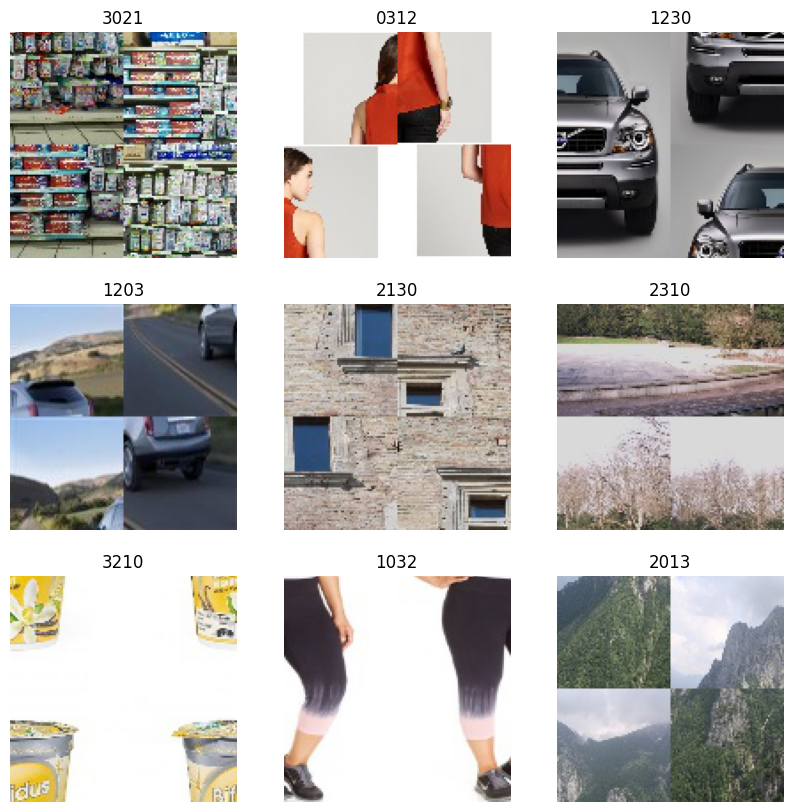

In [49]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [50]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

(32, 128, 128, 3)
(32,)


# Normalizing the data

In [51]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [52]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Setting up the layers

In [70]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
num_classes = len(class_names)

# Include dropout layers to randomly drop some output units
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, name="outputs")
])

# Compile stage

In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

checkpoint_path = "../output/cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Fit and train model

In [72]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

Epoch 1/25
1244/1244 [==============================] - ETA: 0s - loss: 1.0795 - accuracy: 0.6561
Epoch 1: saving model to ../output\cp1.ckpt
1244/1244 [==============================] - 209s 168ms/step - loss: 1.0795 - accuracy: 0.6561 - val_loss: 0.6720 - val_accuracy: 0.7753
Epoch 2/25
1244/1244 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.8062
Epoch 2: saving model to ../output\cp1.ckpt
1244/1244 [==============================] - 214s 172ms/step - loss: 0.5664 - accuracy: 0.8062 - val_loss: 0.5510 - val_accuracy: 0.8135
Epoch 3/25
1244/1244 [==============================] - ETA: 0s - loss: 0.4279 - accuracy: 0.8519
Epoch 3: saving model to ../output\cp1.ckpt
1244/1244 [==============================] - 202s 162ms/step - loss: 0.4279 - accuracy: 0.8519 - val_loss: 0.5082 - val_accuracy: 0.8223
Epoch 4/25
1244/1244 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8772
Epoch 4: saving model to ../output\cp1.ckpt
1244/1244 [==========

In [67]:
new_model = tf.keras.models.load_model('unscramble_model.h5')

# Check its architecture
new_model.summary()

# Evaluate the restored model
loss, acc = new_model.evaluate(val_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(val_ds).shape)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)       

In [69]:
new_model.save('unscramble_model.h5')

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback]
)

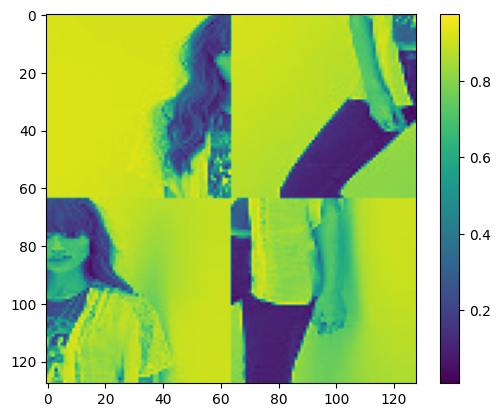

Incorrect


In [9]:
# Plotting to see the data
idx = 1000
plt.figure()
plt.imshow(testing_images[idx])
plt.colorbar()
plt.grid(False)
plt.show()
training_images.shape
type(training_labels)
training_images[1].shape
print(class_names[testing_labels[idx]])

# Evaluate Test Cases (Ignore)

In [10]:
test_loss, test_acc = model.evaluate(testing_images,  testing_labels, verbose=2)

print('\nTest accuracy:', test_acc)

375/375 - 1s - loss: 0.0571 - accuracy: 0.9839 - 853ms/epoch - 2ms/step

Test accuracy: 0.9839166402816772


# Make Predictions (Ignore)

In [11]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(testing_images)

idx = 2

print(predictions[idx])

print("Prediction: {:d}".format(np.argmax(predictions[idx])))
print("Reality: {:d}".format(testing_labels[idx]))

375/375 [==============================] - 1s 2ms/step
[5.297678e-07 9.999995e-01]
Prediction: 1
Reality: 1


# Plotting results (Ignore)

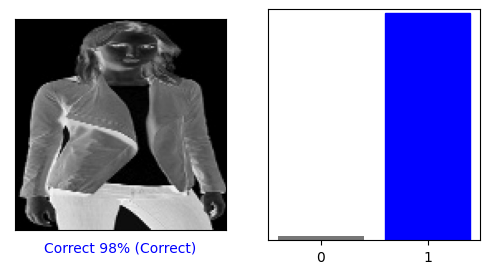

In [12]:
# Taken from https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], testing_labels, testing_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  testing_labels)
plt.show()

Plot the first X test images, their predicted labels, and the true labels.  
Color correct predictions in blue and incorrect predictions in red.

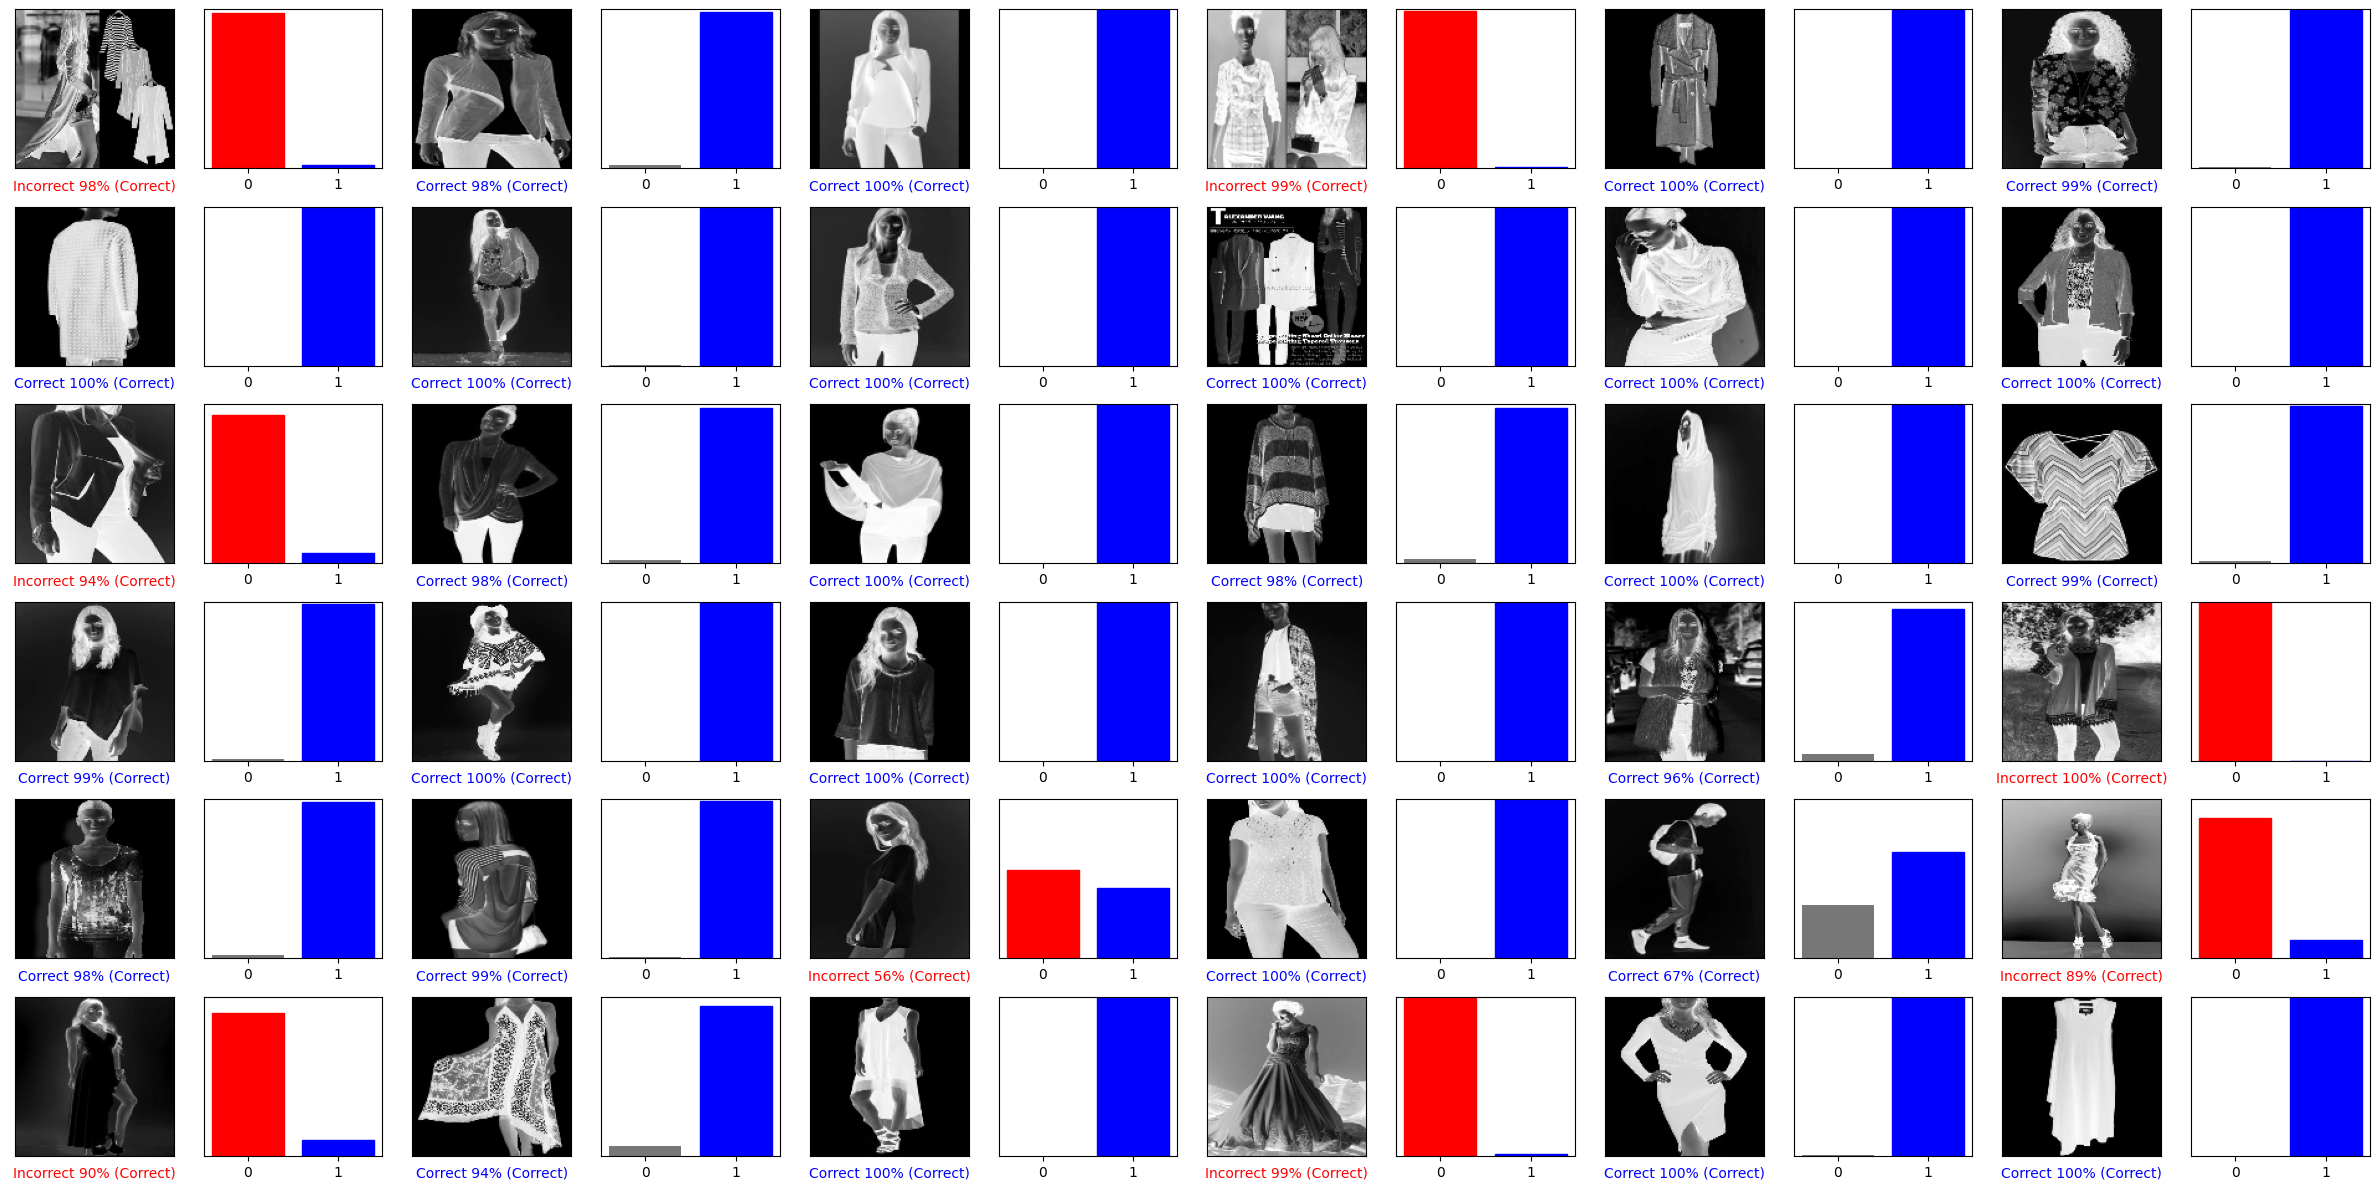

In [13]:
# Modified from https://www.tensorflow.org/tutorials/keras/classification
num_rows = 6
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], testing_labels, testing_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], testing_labels)
plt.tight_layout()
plt.show()

# Using the trained model

(128, 128)
(1, 128, 128)
1/1 [==============================] - 0s 68ms/step
[[0.01738736 0.9826126 ]]


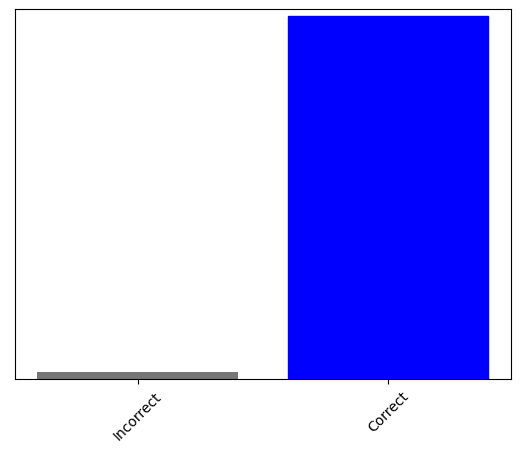

In [14]:
# Grab an image from the test dataset.
img = testing_images[1]

print(img.shape)

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

# Now predict the correct label for this image:

predictions_single = probability_model.predict(img)

print(predictions_single)

plot_value_array(1, predictions_single[0], testing_labels)
_ = plt.xticks(range(2), class_names, rotation=45)
np.argmax(predictions_single[0])
plt.show()

# Saving the trained model

In [73]:
model.save('unscramble_model.h5')